# Kaggle competition - Titanic
https://www.kaggle.com/c/titanic

## Load raw data & library

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 

In [2]:
path = '/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/titanic/'

In [3]:
train_df = pd.read_csv(path+ 'train.csv')
test_df = pd.read_csv(path+ 'test.csv')
submmit = pd.read_csv(path+'gender_submission.csv')

data_df = train_df.append(test_df)
data_df.reset_index(inplace=True, drop=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [5]:
data_df.count()

Age            1046
Cabin           295
Embarked       1307
Fare           1308
Name           1309
Parch          1309
PassengerId    1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
dtype: int64

## Feature engineering 

### Name to be Title

In [6]:
data_df['Name'].describe()

count                 1309
unique                1307
top       Kelly, Mr. James
freq                     2
Name: Name, dtype: object

In [7]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)

In [8]:
data_df['Title'].describe()

count     1309
unique       6
top         Mr
freq       767
Name: Title, dtype: object

### Age

In [9]:
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute

### Family_Survival

In [10]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [11]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

Number of passenger with family/group survival information: 546


### Sex

In [12]:
data_df['Sex'].replace(['male','female'],[0,1],inplace=True)

### Input feature

In [13]:
col = ['Survived', 'Pclass', 'Sex', 'Family_Survival', 'Fare', 'Age']

In [14]:
data = data_df[col]

In [15]:
data.head()

,Survived,Pclass,Sex,Family_Survival,Fare,Age
0,0.0,3,0,0.5,7.2500,22.0
1,1.0,1,1,0.5,71.2833,38.0
2,1.0,3,1,0.5,7.9250,26.0
3,1.0,1,1,0.0,53.1000,35.0
4,0.0,3,0,0.5,8.0500,35.0


## ML training model

In [34]:
def split_data(a,n): return a[:n].copy(), a[n:].copy()
train_df, test_df = split_data(data,891)

**Train:**

In [35]:
train_y = train_df['Survived']
train_X = train_df.copy()
train_X.drop('Survived', axis = 1, inplace = True)

**Test:**

In [36]:
test_X = test_df.copy()
test_X.drop('Survived', axis = 1, inplace = True)

**training data & validation data:**

In [37]:
trn_prct = 0.7
n_trn = round(len(train_X)*trn_prct)

X_train, X_valid = split_data(train_X, n_trn)
y_train, y_valid = split_data(train_y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((624, 5), (624,), (267, 5))

## train model

In [20]:
def accuracy(y_hat,y): return 1-sum(abs(y_hat-y))/len(y)

def print_score(m):
    res = [accuracy(m.predict(X_train), y_train), accuracy(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### random forest

Public Score: 0.78947

In [21]:
m = RandomForestClassifier(random_state=2, n_estimators=250, n_jobs=-1, oob_score=True, min_samples_leaf=3, max_features=0.5)
m.fit(train_X, train_y)
print_score(m)

[0.9022435897435898, 0.9213483146067416, 0.9022435897435898, 0.9213483146067416, 0.8417508417508418]


* 'Age' older 20 years old are considered to be 20 years old.
* 'Fare' higher 80 dollar are considered to be 80 dollar.
* Public Score: 0.80861

In [38]:
m = RandomForestClassifier(random_state=2, n_estimators=250, n_jobs=-1, oob_score=True, min_samples_leaf=3, max_features=0.5)
m.fit(train_X, train_y)
print_score(m)

[0.875, 0.9026217228464419, 0.875, 0.9026217228464419, 0.856341189674523]


## predict & submmit

In [39]:
rf_res = m.predict(test_X)

In [40]:
submmit = pd.read_csv(path+'gender_submission.csv')
submmit['Survived'] = rf_res
submmit = submmit.astype(int)
submmit.to_csv(path+'gender_submission.csv', index=False)

In [41]:
! kaggle competitions submit titanic -f {path+'gender_submission.csv'} -m "My submission-RF-v2"

100%|████████████████████████████████████████| 2.77k/2.77k [00:10<00:00, 268B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

## Feature importance

In [26]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [27]:
fi = rf_feat_importance(m, train_X);fi

,cols,imp
1,Sex,0.359818
3,Fare,0.200210
4,Age,0.181886
2,Family_Survival,0.160961
0,Pclass,0.097125


## Partial dependence

In [28]:
from pdpbox import pdp
from plotnine import *

In [29]:
def plot_pdp(feat_name, clusters=None):
    p = pdp.pdp_isolate(m, train_X, feature=feat_name, model_features=train_X.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa4ea353780>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa4f8d88240>})

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


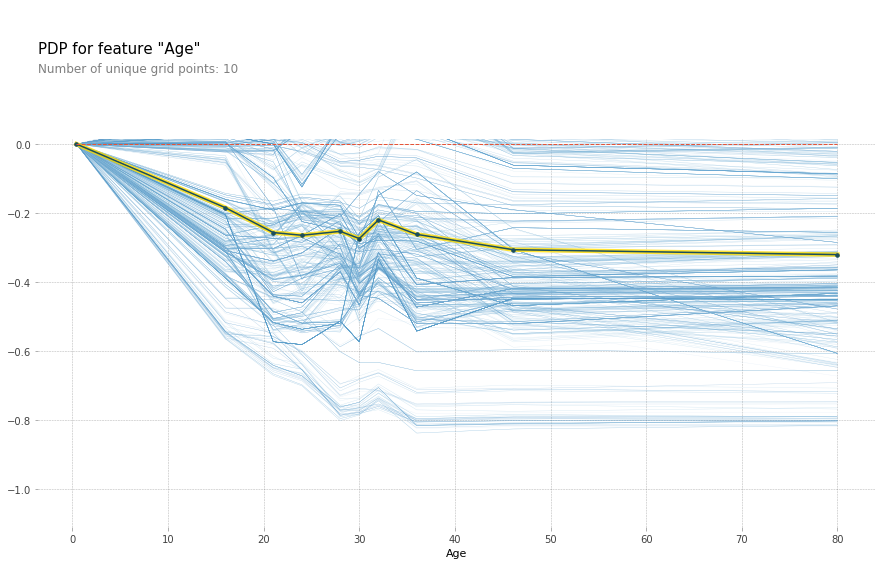

In [30]:
plot_pdp('Age')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa4eb0c63c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa4eb059390>})

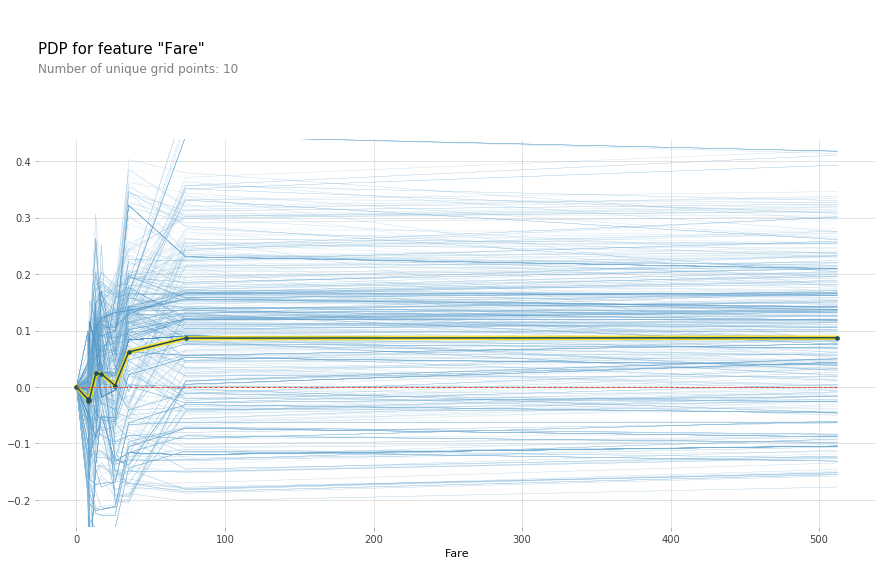

In [31]:
plot_pdp('Fare')

### Feature engineering again

In [32]:
data.Fare[data.Fare >80] = 80

In [33]:
data.Age[data.Age >20] = 20